<a href="https://colab.research.google.com/github/JakeOh/202505_BD50/blob/main/lab_da/ml17_ann_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST 이미지 분류

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [3]:
tf.__version__

'2.19.0'

In [4]:
keras.__version__

'3.10.0'

In [5]:
print(keras.config.backend())  # Keras 라이브러리에서 신경망 계산을 할 때 필요한 라이브러리.

tensorflow


In [6]:
print(tf.config.list_physical_devices())  # CPU/GPU/TPU 사용 여부 확인

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Keras 라이브러리는 GPU 연산을 직접 수행하지 않음. 대신에 GPU 연산을 수행하는 다른 딥러닝 라이브러리를 백엔드(backend)로 활용함.

*   Keras에서 사용할 수 있는 백엔드 종류
    *   TensorFlow - Google에서 만든 텐서(Tensor) 연산을 빠르게 수행하기 위한 라이브러리.
    *   PyTorch - Meta(페이스북)에서 만든 딥러닝 라이브러리 -> 리눅스 재단으로 오픈소스로 공개.
*   Keras
    *   여러가지 백엔드를 사용해서 신경망을 쉽게 만들고 사용할 수 있도록 만든 고급 라이브러리.
    *   2.3.1 버전 이후부터는 TensorFlow만 단일 백엔드로 사용하도록 기능 변경.
    *   3.0 버전부터 다시 멀티 백엔드 정책으로 바뀜.

# Fashion MNIST 데이터 셋

10가지 패션 아이템의 28x28 크기의 흑백 이미지 60,000개 훈련 셋/레이블, 10,000개 테스트 셋/레이블.

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# (훈련 셋, 훈련 레이블), (테스트 셋, 테스트 레이블)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
x_train.shape  # (n_samples, image_width, image_height)

(60000, 28, 28)

In [9]:
y_train.shape

(60000,)

In [10]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [11]:
x_test.shape

(10000, 28, 28)

In [12]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

훈련셋, 테스트셋 모두 각 클래스의 샘플들이 동일한 개수로 만들어져 있음.

데이터셋의 이미지를 시각화해 보세요.

In [13]:
def plot_fashion_mnist(arr, ncols=10):
    # arr: (samples, width, height) shape의 3차원 배열
    # ncols: subplot axis의 컬럼 개수.
    n = len(arr)  # 출력할 이미지 개수
    nrows = int(np.ceil(n / ncols))  # subplot Axis 행 개수.
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j  # arr에서 선택할 이미지 인덱스.
            if nrows == 1 or ncols == 1:  # ax가 1차원 배열인 경우
                if idx < n:
                    ax[idx].imshow(arr[idx], cmap=plt.cm.binary)
                ax[idx].axis('off')
            else:  # ax가 2차원 배열인 경우
                if idx < n:
                    ax[i, j].imshow(arr[idx], cmap=plt.cm.binary)
                ax[i, j].axis('off')
    plt.show()

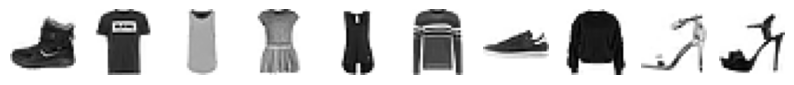

In [14]:
plot_fashion_mnist(x_train[:10])

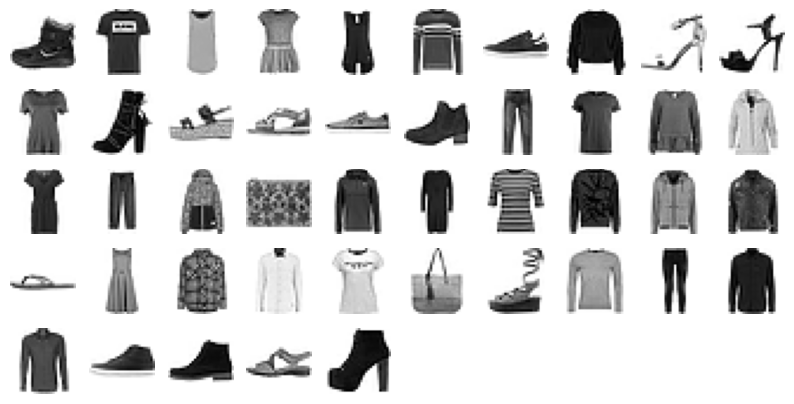

In [15]:
plot_fashion_mnist(x_train[:45])

# 훈련 셋/레이블을 훈련 셋과 검증 셋으로 분리

In [16]:
train_data, val_data, train_target, val_target = \
        train_test_split(x_train, y_train, random_state=42, test_size=0.2, stratify=y_train)

In [17]:
print(train_data.shape)
print(train_target.shape)
print(np.unique(train_target, return_counts=True))

(48000, 28, 28)
(48000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800]))


In [18]:
print(val_data.shape)
print(val_target.shape)
print(np.unique(val_target, return_counts=True))

(12000, 28, 28)
(12000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]))


# SGD Classifier

In [19]:
train_data[0]  #> 각 픽셀의 값들이 0(white) ~ 255(white)

array([[  0,   0,   0,   0,   1,   1,   0,   0,   0,  25,  55,   0,   0,
          0,   0,   0,   0,  43,  24,   0,   0,   0,   1,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   1,   1,   0,  25, 147, 189, 181,  96,  51,
         49,  55,  37,  76, 217, 172, 125,  20,   0,   2,   1,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   3,   0,  82, 206, 202, 190, 178, 188, 239,
        152,  99, 199, 201, 162, 176, 192, 185,  71,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0, 202, 196, 181, 188, 183, 169, 179,
        160, 107, 198, 166, 167, 178, 170, 183, 166,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   1,   0,  48, 216, 184, 185, 185, 190, 175, 164,
        188, 198, 188, 157, 183, 176, 171, 167, 175,  26,   0,   2,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  90, 224, 183, 185, 184, 183, 190, 164,
        169, 193, 158, 170, 174, 176, 175, 165, 180,  62,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 123, 228, 184, 180, 183, 178, 183, 172,
        172, 172, 161, 179, 170, 174, 175, 165, 181, 106,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 156, 229, 188, 175, 178, 175, 175, 190,
        157, 157, 180, 169, 169, 172, 171, 161, 179, 143,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 181, 228, 190, 174, 174, 176, 175, 197,
        167, 167, 183, 166, 169, 171, 170, 162, 175, 172,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   6, 175, 221, 192, 170, 174, 176, 175, 193,
        176, 172, 175, 167, 169, 169, 167, 160, 169, 196,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  23, 184, 216, 206, 164, 175, 176, 175, 192,
        178, 175, 174, 167, 166, 169, 169, 165, 169, 175,   6,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  53, 189, 208, 219, 161, 176, 176, 175, 190,
        181, 178, 172, 169, 165, 170, 169, 166, 167, 183,  26,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  84, 194, 207, 216, 157, 176, 175, 176, 193,
        183, 180, 172, 167, 167, 166, 170, 165, 167, 185,  61,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 114, 193, 211, 207, 157, 175, 175, 176, 196,
        183, 181, 172, 166, 166, 165, 170, 164, 169, 187,  88,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 155, 192, 219, 194, 161, 172, 178, 176, 197,
        185, 181, 169, 166, 165, 165, 171, 164, 171, 184, 108,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 181, 192, 225, 185, 162, 172, 179, 176, 199,
        185, 183, 169, 166, 164, 164, 172, 161, 170, 184, 135,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 210, 189, 233, 180, 161, 171, 179, 179, 201,
        185, 190, 166, 166, 164, 164, 176, 158, 171, 183, 155,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 229, 184, 234, 176, 164, 169, 180, 183, 198,
        185, 193, 166, 167, 164, 165, 179, 157, 176, 179, 174,   0,   0,
          0,   0],
       [  0,   0,   0,   2, 237, 183, 237, 171, 166, 167, 178, 188, 196,
        187, 196, 164, 166, 165, 166, 179, 157, 178, 176, 185,   2,   0,
          0,   0],
       [  0,   0,   0,  24, 246, 184, 255, 172, 166, 169, 180, 192, 196,
        189, 201, 161, 164, 165, 165, 181, 161, 181, 176, 189,  17,   0,
          0,   0],
       [  0,   0,   0,  52, 247, 187, 238, 166, 170, 170, 180, 198, 193,
        189, 207, 160, 165, 165, 164, 180, 162, 187, 175, 192,  52,   0,
          0,   0],
       [  0,   0,   0,  82, 215, 192, 239, 158, 169, 174, 179, 207, 189,
        187, 213, 160, 167, 166, 165, 181, 169, 190, 170, 192,  73,   0,
          0,   0],
       [  0,   0,   0, 102, 212, 201, 212, 166, 169, 171, 179, 217, 189,
        187, 217, 157, 170, 167, 166, 178, 171, 196, 169, 171,  84,   0,
          0,   0],
       [  0,   0,   0, 166, 211, 213, 193, 164, 170, 170, 180, 226, 181,
        187, 228, 157, 167, 167, 158, 188, 196, 128, 170, 179, 128,   0,
          0,   0],
       [  0,   0,   0,  35,  92, 129, 19

In [20]:
# 훈련 셋의 픽셀 값을 0 ~ 1 사이의 값으로 스케일링 -> 확률적 경사 하강법 성능을 높이기 위해서.
train_data_scaled = train_data / 255.0

In [21]:
train_data_scaled[0]

array([[0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.00392157, 0.        , 0.        , 0.        , 0.09803922,
        0.21568627, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16862745, 0.09411765, 0.        ,
        0.        , 0.        , 0.00392157, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00392157, 0.00392157,
        0.00392157, 0.        , 0.09803922, 0.57647059, 0.74117647,
        0.70980392, 0.37647059, 0.2       , 0.19215686, 0.21568627,
        0.14509804, 0.29803922, 0.85098039, 0.6745098 , 0.49019608,
        0.07843137, 0.        , 0.00784314, 0.00392157, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00392157, 0.01176471,
        0.        , 0.32156863, 0.80784314, 0.79215686, 0.74509804,
        0.69803922, 0.7372549 , 0.9372549 , 0.59607843, 0.38823529,
        0.78039216, 0.7882

In [22]:
sgd = SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1)

In [23]:
sgd.fit(X=train_data_scaled.reshape((48_000, -1)), y=train_target)

SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42)

In [24]:
sgd.intercept_  #> shape: (10,)

array([ -1.54024535,  -4.97085256,  -2.45411884,  -1.5496291 ,
        -4.94592029,   3.66151889,  -1.47955462,  -1.90241534,
        -4.40078057, -25.19876253])

In [25]:
sgd.coef_.shape  #> (10, 784)

(10, 784)

In [26]:
predict_probas = sgd.predict_proba(X=train_data_scaled.reshape((48_000, -1)))

In [27]:
predict_probas.shape  #> (48_000, 10)

(48000, 10)

In [28]:
predict_probas[:5]

array([[1.20888251e-02, 1.05549631e-05, 2.30094285e-01, 3.41231387e-03,
        4.86284532e-02, 3.96063160e-10, 6.91742929e-01, 1.54454383e-17,
        1.40226378e-02, 1.05805064e-16],
       [7.53889861e-01, 1.20438290e-04, 4.89841116e-05, 2.88644150e-04,
        7.52168267e-02, 4.15812599e-17, 1.69806662e-01, 2.22627871e-15,
        6.28584469e-04, 3.41774283e-15],
       [2.89450403e-03, 2.51542365e-04, 1.32250305e-04, 9.78121334e-01,
        2.43557068e-04, 8.15414752e-12, 1.83430550e-02, 1.32044303e-06,
        1.24368179e-05, 1.15226778e-10],
       [1.87927047e-02, 1.53865511e-02, 4.75084700e-03, 9.59873842e-01,
        2.15421676e-04, 2.30937550e-07, 4.85837345e-04, 7.79498173e-08,
        4.94463323e-04, 2.39574997e-08],
       [9.71611164e-01, 8.55700455e-07, 2.35430174e-03, 2.77866962e-07,
        7.27359445e-06, 2.50343665e-19, 2.58251753e-02, 6.13245802e-16,
        2.00951140e-04, 2.02813751e-10]])

In [29]:
predicts = sgd.predict(X=train_data_scaled.reshape((48_000, -1)))

In [30]:
predicts.shape  #> (48_000,)

(48000,)

In [31]:
predicts[:5]

array([6, 0, 3, 3, 0], dtype=uint8)

In [32]:
accuracy_score(train_target, predicts)  # 훈련 셋 정확도

0.8518125

In [33]:
# 검증 셋의 모든 픽셀을 0 ~ 1 사이로 스케일링
val_data_scaled = val_data / 255.0
# 검증 셋의 예측값
val_predicts = sgd.predict(X=val_data_scaled.reshape((12_000, -1)))
# 검증 셋의 정확도
accuracy_score(y_true=val_target, y_pred=val_predicts)

0.8468333333333333

# 신경망

Keras 라이브러리를 사용해서 입력층과 출력층만 갖는 신경망을 만들고 테스트하세요.

In [34]:
tr_data_scaled_flat = train_data_scaled.reshape((48_000, -1))  #> shape: (48_000, 784)
val_data_scaled_flat = val_data_scaled.reshape((12_000, -1))   #> shape: (12_000, 784)

In [35]:
print(tr_data_scaled_flat.shape)
print(val_data_scaled_flat.shape)

(48000, 784)
(12000, 784)


In [36]:
inputs = keras.layers.Input(shape=(784,))  # 입력층

In [37]:
dense = keras.layers.Dense(units=10, activation='softmax')  # 출력층

In [38]:
model = keras.Sequential(layers=[inputs, dense])  # 완전 연결 신경망

In [39]:
model.summary()
#> 모델 파라미터 개수 = (784 weight * 10 output) + 10 bias =  7,850

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [41]:
model.fit(x=tr_data_scaled_flat, y=train_target, epochs=5, verbose=0)

In [42]:
predicts = model.predict(x=tr_data_scaled_flat)
#> 48,000개 이미지의 각 레이블이 될 확률을 리턴.

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [43]:
predicts.shape  #> (48_000 이미지 샘플, 10개 확률)

(48000, 10)

In [44]:
print(predicts[:2])

[[4.4224034e-03 2.7783672e-05 9.9849194e-02 1.4487952e-02 3.1785723e-02
  3.3382899e-13 8.4862101e-01 1.0319313e-17 8.0596650e-04 2.8798280e-17]
 [5.8696866e-01 3.0089254e-06 5.9541286e-04 6.2308493e-03 6.5446123e-03
  1.2002552e-20 3.9961076e-01 2.3510100e-18 4.6651374e-05 2.5588113e-18]]


In [45]:
tr_pred_labels = predicts.argmax(axis=1)
# argmax(): 최댓값의 인덱스를 리턴. 10개의 확률들 중 최댓값의 인덱스가 예측 레이블이 됨.

In [46]:
tr_pred_labels.shape

(48000,)

In [47]:
tr_pred_labels[:2]

array([6, 0])

In [48]:
accuracy_score(y_true=train_target, y_pred=tr_pred_labels)

0.857

In [49]:
# 훈련 셋 평가 - model의 evaluate 메서드를 사용할 수도 있음.
model.evaluate(x=tr_data_scaled_flat, y=train_target, verbose=0)
#> [loss(손실), accuracy(정확도)]

[0.419798344373703, 0.8569999933242798]

In [50]:
# 검증 셋 평가
model.evaluate(x=val_data_scaled_flat, y=val_target, verbose=0)

[0.4203130006790161, 0.856083333492279]

# 활성화 함수(Activation Function)

*   활성화 함수: 신경망의 각 층(layer)에서 출력을 내보내는 함수.
*   신경망의 은닉층(hidden layer)에서 선형함수를 사용하면 여러 개의 층을 연결하는 효과가 없고, 단일 층을 사용하는 것과 같아짐.
*   은닉층에서는 비선형 함수를 활성화 함수로 사용.

## Sigmoid

$
\text{sigmoid}(x) = \dfrac{1}{1 + \exp(-x)}
$

In [51]:
xvals = np.arange(-5, 5, 0.0001)

In [52]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [53]:
yvals = sigmoid(xvals)

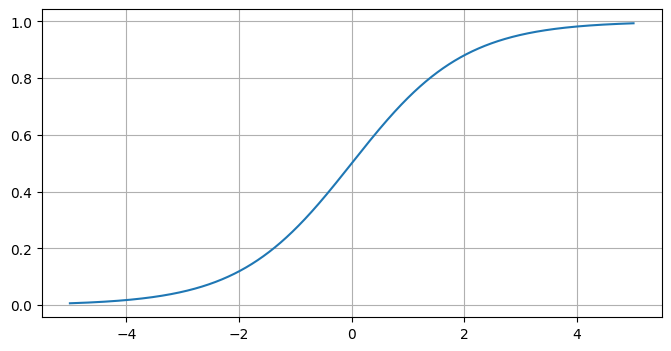

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(xvals, yvals)
plt.grid()
plt.show()

## Hyperbolic tangent

In [55]:
def plot_activation_fn(fn):
    xvals = np.arange(-5, 5, 0.0001)
    yvals = fn(xvals)
    plt.figure(figsize=(8, 4))
    plt.plot(xvals, yvals)
    plt.grid()
    plt.show()

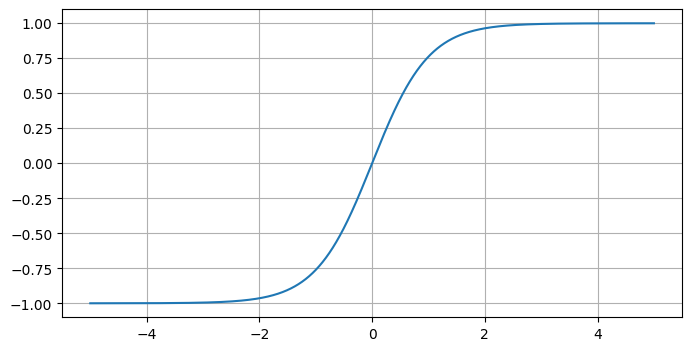

In [56]:
plot_activation_fn(np.tanh)

## ReLU(Rectified Linear Unit)

*   입력값이 양수이면 마치 활성화 함수가 없는 것처럼 입력값 그대로 출력으로 내보냄.
*   입력값이 음수이면 출력값을 0으로 만듦.
*   이미지 처리를 할 때 좋은 성능을 낸다고 알려져 있음.

$
\text{ReLU}(x) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    0 & \text{for } x \lt 0
\end{cases}
$

In [57]:
def relu(x):
    return np.maximum(x, 0)

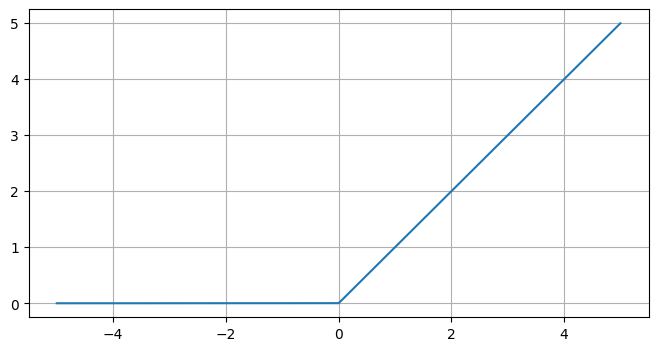

In [58]:
plot_activation_fn(relu)

## Leaky ReLU

$
\text{LeakyReLU}(x, \alpha) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    \alpha x & \text{for } x \lt 0
\end{cases}
$

In [59]:
def leaky_relu(x, alpha=0.1):
    # 0 <= alpha <= 1
    return np.maximum(x, alpha * x)

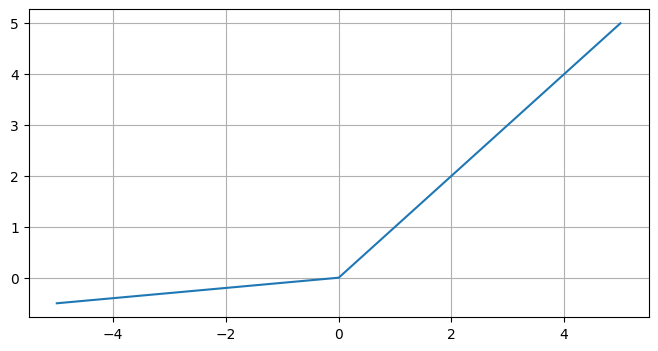

In [60]:
plot_activation_fn(leaky_relu)

## ELU(Exponential Linear Unit)

$
\text{ELU}(x, \alpha) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    \alpha (\exp(x) - 1) & \text{for } x \lt 0
\end{cases}
$

In [61]:
def elu(arr, alpha=1):
    # 0 <= alpha
    result = []
    for x in arr:
        if x >= 0:
            result.append(x)
        else:
            result.append(alpha * (np.exp(x) - 1))
    return np.array(result)

In [62]:
def elu(x, alpha=1):
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

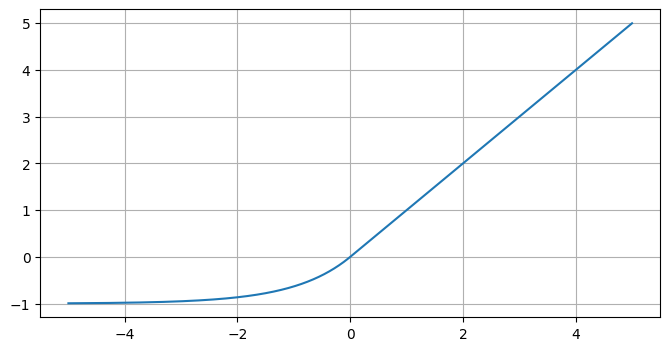

In [63]:
plot_activation_fn(elu)

은닉층에서의 활성화 함수 선택: ELU > LeakyReLU > ReLU > tanh > sigmoid

## ReLU를 활성화 함수로 사용하는 은닉층

In [64]:
model = keras.Sequential()

In [65]:
model.add(keras.Input(shape=(28, 28)))  # 입력층

In [66]:
model.add(keras.layers.Flatten())  # (28, 28) shape의 배열을 (784,) shape으로 변환

In [67]:
# 100개 unit을 갖는, ReLU를 활성화 함수로 사용하는 은닉층을 추가
model.add(keras.layers.Dense(units=100, activation='relu'))

In [68]:
# 출력층 - 다중 클래스 분류. 10개의 unit을 갖고 softmax를 활성화 함수로 사용하는 층.
model.add(keras.layers.Dense(units=10, activation='softmax'))

In [69]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# 모델 컴파일
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [71]:
# 모델 훈련
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6823 - sparse_categorical_accuracy: 0.7617
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4056 - sparse_categorical_accuracy: 0.8519
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.3622 - sparse_categorical_accuracy: 0.8689
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3342 - sparse_categorical_accuracy: 0.8802
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3190 - sparse_categorical_accuracy: 0.8861


In [72]:
# 모델 평가 - 훈련 셋의 손실/정확도
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3106 - sparse_categorical_accuracy: 0.8903


[0.313035249710083, 0.8898749947547913]

In [73]:
# 모델 평가 - 검증 셋의 손실/정확도
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3611 - sparse_categorical_accuracy: 0.8772


[0.35675784945487976, 0.8793333172798157]

## ELU를 활성화 함수로 사용하는 은닉층

In [74]:
model = keras.Sequential()
model.add(keras.Input(shape=(28, 28)))  # 입력층
model.add(keras.layers.Flatten())  # Flatten layer: 2차원 입력 배열 -> 1차원 배열
model.add(keras.layers.Dense(units=100, activation='elu'))  # 은닉층(hidden layer)
model.add(keras.layers.Dense(units=10, activation='softmax'))  # 출력층

In [75]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [77]:
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6715 - sparse_categorical_accuracy: 0.7613
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4063 - sparse_categorical_accuracy: 0.8530
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3628 - sparse_categorical_accuracy: 0.8693
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.3384 - sparse_categorical_accuracy: 0.8751
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3242 - sparse_categorical_accuracy: 0.8815


In [78]:
model.evaluate(x=train_data_scaled, y= train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2957 - sparse_categorical_accuracy: 0.8908


[0.29755404591560364, 0.8905624747276306]

In [79]:
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3302 - sparse_categorical_accuracy: 0.8810


[0.3308306336402893, 0.8825833201408386]

# Optimizer

*   경사 하강법(Gradient Descent)
    *   손실 함수를 최소로 만드는 가중치들을 찾는 방법.

$
w_{next} = w_{init} - 학습률 \cdot 기울기
$

*   아주 큰 신경망인 경우는 모델 훈련을 통해서 찾아야 하는 모델 파라미터들의 개수가 매우 많음.
*   모델 파라미터들의 개수가 많을 수록 훈련 속도가 심각하게 느려질 수 있음.
*   훈련 속도를 높이는 방법:
    *   좋은 초기화 전략 사용하기
    *   좋은 활성화 함수 사용하기
    *   배치 정규화 사용하기
    *   사전 훈련된 네트워크(신경망)의 일부를 재사용.
    *   일반적인 경사 하강법 대신 더 빠른 옵티마이저를 사용하기.
*   확률적 경사 하강법(SGD)의 변종 옵티마이저
    *   학습률(learning_rate) 파라미터를 변경.
    *   모멘텀 최적화(momentum optimization): 모멘텀(momentum) 파라미터 값을 0보다 큰 값으로 변경.
    *   네스테로프 가속 경사(Nesterov Accelerated Gradient, NAG): nesterov 파라미터를 True로 설정.
*   적응형 학습률(adaptive learning rate): 학습할 때마다 학습률을 변화시킴.
    *   RMSprop(Root Mean Squared Propagation): Sequential 클래스의 compile 메서드의 optimizer 기본값.
    *   Adam(Adaptive Momentum Estimation): 모멘텀 최적화 + RMSprop
    *   Nadam: Adam + Nesterov
    *   AdaGrad

## SGD optimizer

In [80]:
def create_model(layers=None):
    # layers: keras.layers 객체들의 배열/리스트.
    model = keras.Sequential()  # Seqential 모델 생성
    model.add(keras.Input(shape=(28, 28)))  # 입력층 추가
    model.add(keras.layers.Flatten())  # Flatten layer 추가
    model.add(keras.layers.Dense(units=100, activation='relu'))  # 첫번째 은닉층을 추가
    if layers:  # 아규먼트로 전달된 은닉층들이 있으면
        for layer in layers:
            model.add(layer)
    model.add(keras.layers.Dense(units=10, activation='softmax'))  # 출력층 추가

    return model

In [81]:
model = create_model()

In [82]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
# 옵티마이저: 학습률 변경, 모멘텀 최적화, 네스테로프 가속 경사
op = keras.optimizers.SGD(learning_rate=0.02, momentum=0.1, nesterov=True)
model.compile(optimizer=op,
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [84]:
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9007 - sparse_categorical_accuracy: 0.7003
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5018 - sparse_categorical_accuracy: 0.8259
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4479 - sparse_categorical_accuracy: 0.8436
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4203 - sparse_categorical_accuracy: 0.8528
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4065 - sparse_categorical_accuracy: 0.8575


In [85]:
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3955 - sparse_categorical_accuracy: 0.8630


[0.4039419889450073, 0.8595625162124634]

In [86]:
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4116 - sparse_categorical_accuracy: 0.8535


[0.4060603976249695, 0.8575833439826965]

## Adam optimizer

*   `learning_rate` 파라미터: 학습률
*   `beta_1`, `beta_2` 파라미터: 모멘텀 최적화와 관련된 파라미터.
*   `epsilon` 파라미터: 적응형 학습률과 관련된 파라미터.

In [87]:
model = create_model()

In [88]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [89]:
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6668 - sparse_categorical_accuracy: 0.7678
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4007 - sparse_categorical_accuracy: 0.8576
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3524 - sparse_categorical_accuracy: 0.8718
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3213 - sparse_categorical_accuracy: 0.8827
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3050 - sparse_categorical_accuracy: 0.8878


In [90]:
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2849 - sparse_categorical_accuracy: 0.8934


[0.28662389516830444, 0.893625020980835]

In [91]:
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3350 - sparse_categorical_accuracy: 0.8794


[0.33526384830474854, 0.8818333148956299]

# 모델 훈련

In [92]:
model = create_model()  # 은닉층 1개를 갖는 모델을 생성
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])  # 모델 컴파일

In [93]:
result = model.fit(x=train_data_scaled, y=train_target, epochs=5,
                   validation_data=[val_data_scaled, val_target])

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6843 - sparse_categorical_accuracy: 0.7596 - val_loss: 0.3977 - val_sparse_categorical_accuracy: 0.8597
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.4009 - sparse_categorical_accuracy: 0.8555 - val_loss: 0.3988 - val_sparse_categorical_accuracy: 0.8593
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3590 - sparse_categorical_accuracy: 0.8699 - val_loss: 0.3538 - val_sparse_categorical_accuracy: 0.8776
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3411 - sparse_categorical_accuracy: 0.8793 - val_loss: 0.3474 - val_sparse_categorical_accuracy: 0.8831
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.3196 - sparse_categorical_accuracy: 0.8870 - val_loss: 0.3445 - val_sparse_categorical_accuracy: 0.8821


## History 객체

신경망 모델을 훈련(fit)시키는 과정(각각의 epoch)의 기록을 담고 있는 객체. fit 메서드의 리턴 값.

In [94]:
type(result)

keras.src.callbacks.history.History

In [95]:
type(result.history)

dict

In [96]:
hist = result.history
# 각 epoch마다 훈련 셋 손실/정확도, 검증 셋 손실/정확도를 dict로 저장.

In [97]:
hist.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [98]:
hist.items()

dict_items([('loss', [0.5381511449813843, 0.39529287815093994, 0.35894128680229187, 0.333735853433609, 0.3182368576526642]), ('sparse_categorical_accuracy', [0.8097291588783264, 0.8591041564941406, 0.8696249723434448, 0.8805624842643738, 0.8865000009536743]), ('val_loss', [0.3976748585700989, 0.3987599015235901, 0.35380396246910095, 0.34739384055137634, 0.34445610642433167]), ('val_sparse_categorical_accuracy', [0.859666645526886, 0.859250009059906, 0.8775833249092102, 0.8830833435058594, 0.8820833563804626])])

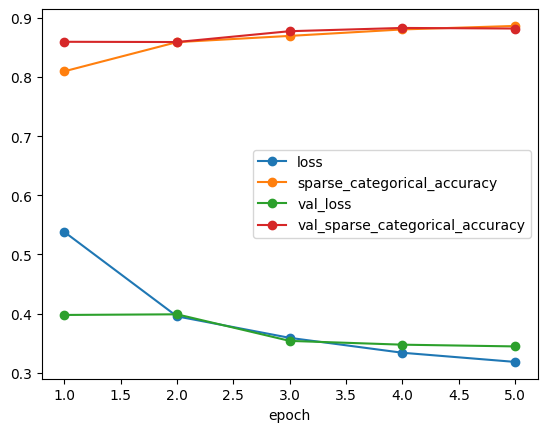

In [99]:
epochs = np.arange(1, 6)
for k, v in hist.items():
    plt.plot(epochs, v, 'o-', label=k)
plt.legend()
plt.xlabel('epoch')
plt.show()

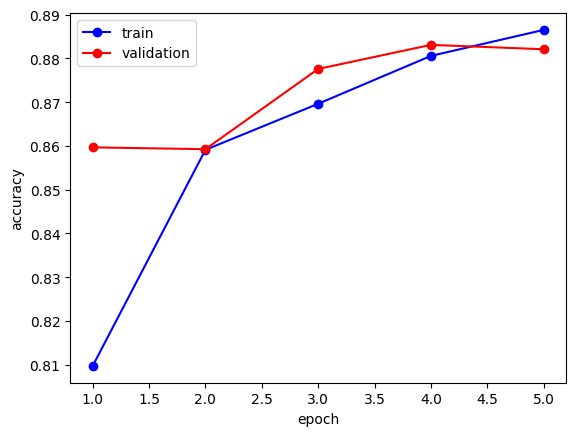

In [102]:
# 정확도 그래프
plt.plot(epochs, hist['sparse_categorical_accuracy'], 'bo-', label='train')
plt.plot(epochs, hist['val_sparse_categorical_accuracy'], 'ro-', label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

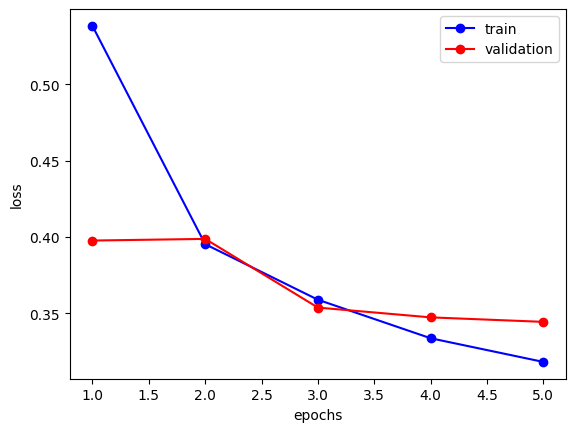

In [103]:
# 손실 그래프
plt.plot(epochs, hist['loss'], 'bo-', label='train')
plt.plot(epochs, hist['val_loss'], 'ro-', label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## RMSprop 옵티마이저 사용

*   100개의 unit으로 이루어진 은닉층 1개를 갖는 신경망 모델 생성
*   RMSprop 옵티마이저를 사용하도록 모델을 컴파일
*   epoch 횟수를 20회로 모델을 훈련시키고 그 결과를 저장.
*   History 객체의 history 속성을 사용해서 훈련 셋과 검증 셋의 손실 그래프를 그려 보세요.

In [104]:
model = create_model()
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])
result = model.fit(x=train_data_scaled, y=train_target, epochs=20,
                   validation_data=[val_data_scaled, val_target])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6709 - sparse_categorical_accuracy: 0.7655 - val_loss: 0.5427 - val_sparse_categorical_accuracy: 0.7973
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.4124 - sparse_categorical_accuracy: 0.8534 - val_loss: 0.3679 - val_sparse_categorical_accuracy: 0.8673
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.3581 - sparse_categorical_accuracy: 0.8689 - val_loss: 0.3641 - val_sparse_categorical_accuracy: 0.8730
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.3401 - sparse_categorical_accuracy: 0.8783 - val_loss: 0.3661 - val_sparse_categorical_accuracy: 0.8784
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.3180 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.3348 - val_sparse_categorical_accuracy: 0.8829
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.3033 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.3550 - val_sparse_categorical_accura

In [105]:
epochs = np.arange(1, 21)

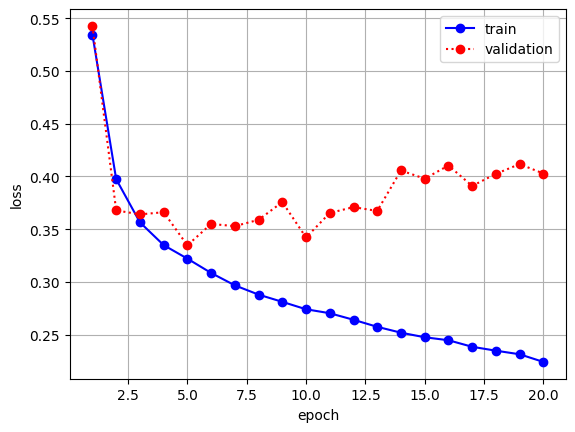

In [107]:
history = result.history
plt.plot(epochs, history['loss'], 'bo-', label='train')
plt.plot(epochs, history['val_loss'], 'ro:', label='validation')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epoch를 5번 이상 실행하면 과대적합의 크기만 더 커짐.

## Adam 옵티마이저 사용

*   위의 과정을 반복

In [108]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])
result = model.fit(x=train_data_scaled, y=train_target, epochs=20,
                   validation_data=[val_data_scaled, val_target])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.7659 - val_loss: 0.3939 - val_sparse_categorical_accuracy: 0.8620
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.3995 - sparse_categorical_accuracy: 0.8570 - val_loss: 0.3653 - val_sparse_categorical_accuracy: 0.8717
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.3590 - sparse_categorical_accuracy: 0.8694 - val_loss: 0.3632 - val_sparse_categorical_accuracy: 0.8717
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3307 - sparse_categorical_accuracy: 0.8812 - val_loss: 0.3433 - val_sparse_categorical_accuracy: 0.8792
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.3099 - sparse_categorical_accuracy: 0.8841 - val_loss: 0.3352 - val_sparse_categorical_accuracy: 0.8803
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.2889 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.3195 - val_sparse_categorical_accura

In [114]:
def plot_train_val_losses(history):
    plt.plot(history.epoch, history.history['loss'], 'bo-', label='train')
    plt.plot(history.epoch, history.history['val_loss'], 'ro:', label='validation')
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

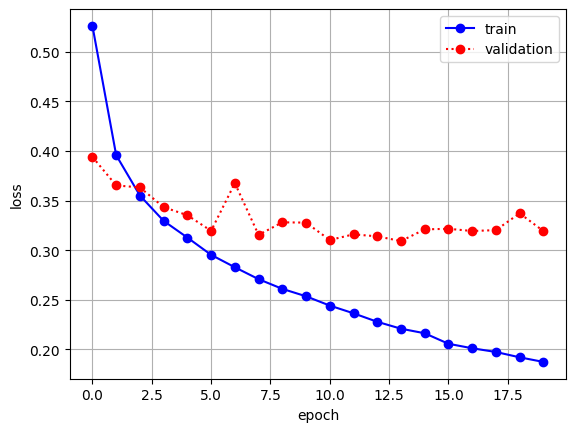

In [115]:
plot_train_val_losses(result)

epoch를 6번 이상 수행하더라도 검증 셋의 손실이 더 이상 작아지지 않음.

# Dropout

*   훈련 과정(epoch)에서 일부 unit의 출력을 0으로 만드는 것(그 다음 layer로 출력값을 전달하지 않음).
*   각 epoch마다 출력을 0으로 만드는 unit은 무작위로 선택.
*   모델의 과대적합을 줄일 수 있음.

In [132]:
model = create_model(layers=[keras.layers.Dropout(rate=0.3)])
# 은닉층 뒤에 30% 비율로 출력을 0으로 만드는 Dropout 계층을 추가

In [133]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [135]:
result = model.fit(x=train_data_scaled, y=train_target, epochs=20,
                   validation_data=[val_data_scaled, val_target])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.7844 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.4098 - val_sparse_categorical_accuracy: 0.8532
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.4460 - sparse_categorical_accuracy: 0.8380 - val_loss: 0.3702 - val_sparse_categorical_accuracy: 0.8677
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.4045 - sparse_categorical_accuracy: 0.8514 - val_loss: 0.3670 - val_sparse_categorical_accuracy: 0.8683
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.3828 - sparse_categorical_accuracy: 0.8604 - val_loss: 0.3555 - val_sparse_categorical_accuracy: 0.8689
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.3664 - sparse_categorical_accuracy: 0.8666 - val_loss: 0.3428 - val_sparse_categorical_accuracy: 0.8778
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.3638 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.3434 - val_sparse_categorical_accur

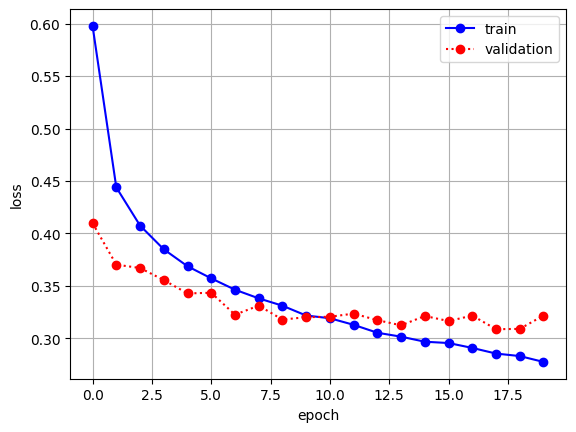

In [136]:
plot_train_val_losses(result)